In [1]:
# Inspired by:
#https://github.com/OceanParcels/GlobalMassBudget/blob/main/create_fisheries_input.py

import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import shapely as sh
import cartopy.io.shapereader as shpreader
import geopandas as gpd
import pandas as pd

In [2]:
def distance(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)
    """

    #Convert decimal degrees to Radians:
    lon1r = np.radians(lon1)
    lat1r = np.radians(lat1)
    lon2r = np.radians(lon2)
    lat2r = np.radians(lat2)

    #Implementing Haversine Formula:
    dlon = np.subtract(lon2r, lon1r)
    dlat = np.subtract(lat2r, lat1r)

    a = np.add(np.power(np.sin(np.divide(dlat, 2)), 2),
                          np.multiply(np.cos(lat1r),
                                      np.multiply(np.cos(lat2r),
                                                  np.power(np.sin(np.divide(dlon, 2)), 2))))

    c = np.multiply(2, np.arcsin(np.sqrt(a)))
    r = 6371

    return c*r

def get_coords_from_polygon(shape):
    """
    Get a list of coordinate points on a Polygon
    (or MultiPolygon) shape

    Based on: https://stackoverflow.com/questions/58844463/how-to-get-a-list-of-every-point-inside-a-multipolygon-using-shapely

    """
    coords = []

    if isinstance(shape, sh.geometry.Polygon):
        coords.append(np.asarray(shape.exterior.coords[:-1]))
        for linearring in shape.interiors:
            coords.append(np.asarray(linearring.coords[:-1]))
    elif isinstance(shape, sh.geometry.MultiPolygon):
        #polygons = list(shape)
        for polygon in shape.geoms:
            coords.append(get_coords_from_polygon(polygon))
    coords = np.concatenate(coords)
    return coords

In [3]:
output_data = '../../data/release/generated_files/'
input_data = '../../data/release/Meijer2021_midpoint_emissions/'

riverData = input_data
riverShapeFile = input_data + 'Meijer2021_midpoint_emissions'


In [4]:
## Download the rivers data from:
## https://figshare.com/articles/dataset/Supplementary_data_for_More_than_1000_rivers_account_for_80_of_global_riverine_plsatic_emissions_into_the_ocean_/14515590

In [5]:
# Load Meijer Data
data = gpd.read_file(riverData)

lon_river = data.geometry.x
lat_river = data.geometry.y
output_river = data['dots_exten'].values #in tonnes per year


# Load in coast mask
data_mask_coast = xr.open_dataset('../../data/output_data/masks/mask_coast_NEMO0083.nc')
coords = xr.open_dataset('../../data/input_data/MOi/domain_ORCA0083-N006/coordinates.nc', decode_cf=False)
mask_coast = data_mask_coast['mask_coast'].values

lats_coast = data_mask_coast['lat'].data[np.where(data_mask_coast['mask_coast'])]
lons_coast = data_mask_coast['lon'].data[np.where(data_mask_coast['mask_coast'])]


In [6]:
# Load Natural Earth dataset for attaching country information to river source
shpfilename = shpreader.natural_earth(resolution='50m',
                                      category='cultural',
                                      name='admin_0_countries')
reader = shpreader.Reader(shpfilename)
countries = reader.records()

countries_list = []
for country in countries:
    continent = country.attributes['CONTINENT']
    region_un = country.attributes['REGION_UN']
    subregion = country.attributes['SUBREGION']
    country_name = country.attributes['NAME_LONG']

    country_coords = get_coords_from_polygon(country.geometry)
    country_lons, country_lats = country_coords[:,0], country_coords[:,1]

    country_df = pd.DataFrame({'Continent': np.repeat(continent, len(country_lons)),
                                'Region': np.repeat(region_un, len(country_lons)),
                                'Subregion': np.repeat(subregion, len(country_lons)),
                                'Country': np.repeat(country_name, len(country_lons)),
                                'Longitude': country_lons,
                                'Latitude': country_lats})
    countries_list.append(country_df)
coastal_df = pd.concat(countries_list)

In [7]:
# Create river emissions dataset
river_emissions_list = []

for i, (lon,lat,output) in enumerate(zip(lon_river,lat_river,output_river)):
    # Find closest coastal cell
    distances = distance(np.repeat(lon, len(lons_coast)), np.repeat(lat, len(lats_coast)), lons_coast, lats_coast)
    closest_coast_id = np.argmin(distances)

    # Find closest country point to river point to assign country information
    distances_country = distance(np.repeat(lon, len(coastal_df['Longitude'])), np.repeat(lat, len(coastal_df['Latitude'])), coastal_df['Longitude'], coastal_df['Latitude'])
    closest_country_id = np.argmin(distances_country)


    river_emissions_list.append({'Continent' : coastal_df['Continent'].iloc[closest_country_id],
                                    'Region' : coastal_df['Region'].iloc[closest_country_id],
                                    'Subregion' : coastal_df['Subregion'].iloc[closest_country_id],
                                    'Country' : coastal_df['Country'].iloc[closest_country_id],
                                    'Longitude' : lons_coast[closest_coast_id],
                                    'Latitude' : lats_coast[closest_coast_id],
                                    'Emissions' : output
                                 })


In [8]:
river_emissions_df = pd.DataFrame.from_records(river_emissions_list)

In [9]:
# Save output
river_emissions_df.to_csv(output_data+'river_emissions_NEMO0083.csv')

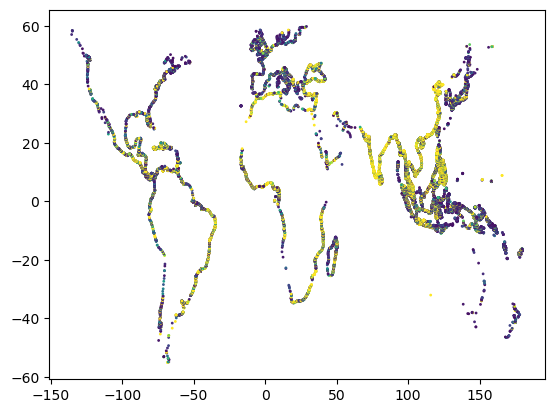

In [10]:
plt.scatter(river_emissions_df['Longitude'],river_emissions_df['Latitude'], c=river_emissions_df['Emissions'], s=1, vmax=2.5)
plt.show()

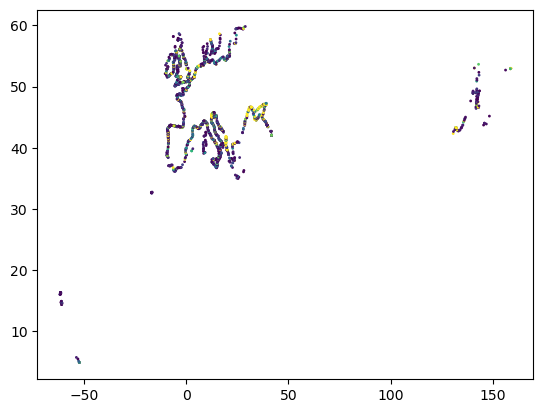

In [11]:
continent_id = (river_emissions_df['Continent'] == 'Europe')

plt.scatter(river_emissions_df['Longitude'][continent_id],river_emissions_df['Latitude'][continent_id], c=river_emissions_df['Emissions'][continent_id], s=1, vmax=2.5)
plt.show()

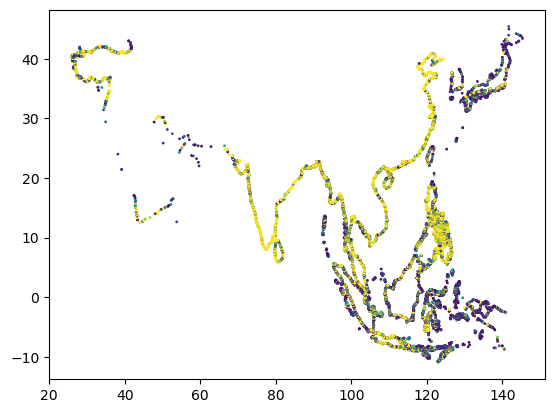

In [12]:
continent_id = (river_emissions_df['Continent'] == 'Asia')

plt.scatter(river_emissions_df['Longitude'][continent_id],river_emissions_df['Latitude'][continent_id], c=river_emissions_df['Emissions'][continent_id], s=1, vmax=2.5)
plt.show()